# Homework 2: Segmantic Segmentation with ConvNets 

In [1]:
# All necessary imports for the project:

import os
import numpy as np
import skimage
import skimage.data
import skimage.io
from pathlib import Path

# Matplotlib for visualization
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

# TensorFlow and parameters:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.python.client import device_lib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Check the GPU
print("Number of GPUs for training: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()


Number of GPUs for training:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11453177135523417025
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22319988736
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 860460073476872702
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

Let's see the distribution of labels in the testing set, done as in exercise 9. 


In [19]:
# Path to the test data 
p = Path('./data/test')
# Label pattern and find files with this pattern
pattern = 'test_lbl*.png'
label_files = list(p.glob(pattern))

first = True
# Bins in the histogram:
r = list(range(257))

# Iterate over all files and compute the histogram, m=maximum pixel value
for file in label_files:
    label =  skimage.io.imread(file)
    if first:
        # Compute the histogram of the label image
        global_histogram, _ = np.histogram(label, bins=r)
        n_labels = 1
        first = False
        m = np.max(label)

    else:
        # Adds the histogram of the current label image to the global histogram
        histogram, _ = np.histogram(label, bins=r)
        global_histogram += histogram
        m2 = np.max(label)
        m = max(m, m2)
        n_labels += 1
        
# Prints the average histogram and the maximum pixel value
print(global_histogram / n_labels)
print(m)

[3.16419492e+00 2.54793750e+03 0.00000000e+00 9.88562500e+02
 9.73867585e+02 2.67949153e+02 6.67847193e+03 1.61374804e+04
 2.10556303e+03 3.09758475e+02 0.00000000e+00 1.61782039e+04
 1.19424258e+03 3.29902013e+02 2.05709746e+01 0.00000000e+00
 0.00000000e+00 3.88047140e+02 3.73993644e+00 3.68326271e+00
 2.55320445e+02 1.09412632e+04 8.62003708e+02 2.01851589e+03
 1.31897775e+02 1.60423729e+01 2.54776430e+03 5.56622881e+02
 2.44385593e+00 0.00000000e+00 2.81991525e+00 0.00000000e+00
 1.08898305e+00 6.90720339e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

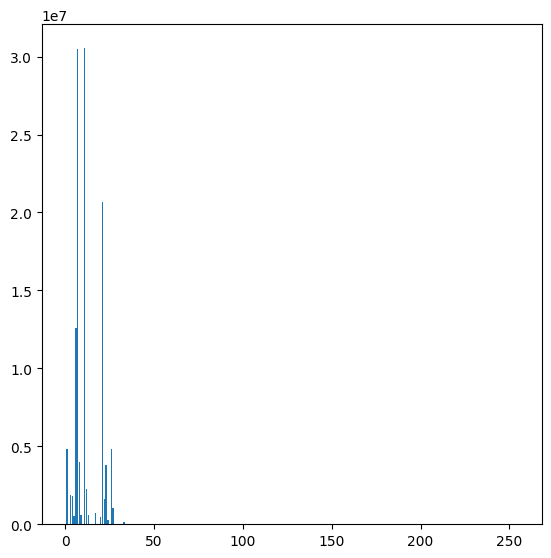

In [3]:
# Plots the global histogram
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(256),global_histogram)
plt.show()

We can see, that there is a significant concentration of the pixel values in the first few bins. The frequency fairly quickly drops off after. Indicating that the higher values are less comon.  

(256, 256, 3)
(256, 256)
The number of unique labels in the label image:  4
{7: 2441, 17: 294, 21: 54181, 22: 8620}


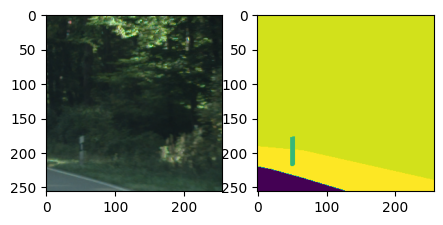

In [21]:
# Lets see an image and it's label: 
selection = '058_12'
image_file = p / ('test_img_' + selection + '.png')
label_file = p / ('test_lbl_' + selection + '.png')

# Load the image and the label and plot them
image = skimage.io.imread(image_file)
print(image.shape)
label = skimage.io.imread(label_file)
print(label.shape)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(label)

# Count the number of unique labels in the label image
unique, counts = np.unique(label, return_counts=True)
print("The number of unique labels in the label image: ", len(unique))
print(dict(zip(unique, counts)))



Using the dataset file provided to create a dataset for training the model. 

In [23]:





def _parse_function(image_filename, label_filename, channels: int):
    """
    Parse image and label and return them. The image is divided by 255.0 and returned as float,
    the label is returned as is in uint8 format.
    Args:
        image_filename: name of the image file
        label_filename: name of the label file
        channels: channels of the input image, (the label is always one channel)
    Returns:
        tensors for the image and label read operations
    """

    ## Image processing: 

    #  Reads raw content of the image into a tensor:
    image_string = tf.io.read_file(image_filename)

    #  Decode the image file contents as a PNG and specify the number of color channels.
    image_decoded = tf.image.decode_png(image_string, channels=channels)

    #  Convert the image data to float32: Set the pixel values from 0-255 to 0-1.
    image_decoded = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
  
     # normalize image to zero mean
    image = tf.multiply(image_decoded, 2.0)
    image = tf.subtract(image, 1.0)
    
    label_string = tf.io.read_file(label_filename)
    label = tf.image.decode_png(label_string, dtype=tf.uint8, channels=1)

    return image, label

def create_dataset(data_dir: str, file_type_str, nr_classes: int,
                   patch_size_width: int, patch_size_height: int, border_size: int, channels: int):
    """
    data_dir: directory of the data
    file_type_str: train, val or test
    nr_classes: number of classes
    patch_size_width: width of the patch
    patch_size_height: height of the patch
    border_size: The size of the border to be trimmed from the label images.
    channels: channels of the input image, (the label is always one channel)

    """
    # Loads the image and label files:
    path = Path(data_dir)
    image_files = list(path.glob(file_type_str+'_img*.png'))
    label_files = list(path.glob(file_type_str+'_lbl*.png'))

    # Sorts the files in the list:
    image_files.sort()
    label_files.sort()

    # Converts the lists to numpy arrays:
    image_files_array = np.asarray([str(p) for p in image_files])
    label_files_array = np.asarray([str(p) for p in label_files])

    print(image_files_array)

    # Creates a tensorflow dataset:
    dataset = tf.data.Dataset.from_tensor_slices((image_files_array,
                                                  label_files_array))
   
    # shuffle the filename, unfortunately, then we cannot cache them
    dataset = dataset.shuffle(buffer_size=10000)
    
    # Use the _parse_function to read the images and labels:
    dataset = dataset.map(lambda image, file:
                          _parse_function(image, file, channels))
    
    # Ensure, that the dimensions of the images and labels are correct and the same:
    # x = image, y = label
    dataset = dataset.map(lambda x, y:
                          (tf.reshape(x, shape=(patch_size_width, patch_size_height, 3)),
                           tf.reshape(y, shape=(patch_size_width, patch_size_height))))
   
    # cut center of the label image in order to use valid filtering in the network
    # 
    b = border_size
    if b != 0:
        dataset = dataset.map(lambda x, y:
                              (x, y[b:-b, b:-b]))
        
    # we use one hot encoded, there seem to be less problems with accuracy etc.
    dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, depth=nr_classes, dtype=tf.float32)))
    return dataset, image_files_array.size


In [28]:
# Parameters for the model:
NUM_CLASSES = 34
PATCH_SIZE_WIDTH = 256
PATCH_SIZE_HEIGHT = 256
batch_size = 32
border = 0

# Defining the paths to the data:
train_dir = './data/train_small'
test_dir = './data/test'
val_dir = './data/val'


dataset_train, nr_images = create_dataset(train_dir,
                                          'train',
                                          nr_classes=NUM_CLASSES,
                                          patch_size_width=PATCH_SIZE_WIDTH,
                                          patch_size_height=PATCH_SIZE_HEIGHT,
                                          border_size=border,
                                          channels=3)
dataset_train = dataset_train.batch(batch_size).repeat()


['data/train_small/train_img_000_00.png'
 'data/train_small/train_img_000_01.png'
 'data/train_small/train_img_000_02.png' ...
 'data/train_small/train_img_121_29.png'
 'data/train_small/train_img_121_30.png'
 'data/train_small/train_img_121_31.png']
